## 아주쉬운 유전체 분석 - 실습편(2019)

    작성일자 : 2020/05/26
    작성자 : 조예슬

    강의 : 제 11강
           Differentially expressed genes using DESeq (아주대 지별아) - 1. Data analysis 이론 설명
           
           제 12강
           Differentially expressed genes using DESeq (아주대 지별아) - 2. DESeq 실습 - 1
           
           제 13강
           Differentially expressed genes using DESeq (아주대 지별아) - 2. DESeq 실습 - 2           

### Genomic data analysis
    - Permutation Test
    - Multiple Testing
    - FDR(False Discovery Rate)
    - DESeq

#### Permutation Test
    : 측정된 dataset에서 무작위로 샘플을 생성해서 p-value를 계산하는 방법
    1) 주어진 데이터의 샘플을 무작위로 추출함
    2) 원래 주어진 샘플의 통계값이 무작위 추출된 통계값과 비교하여 차이 나는지를 검정하는 방법

In [1]:
library(coin)
library(perm)

Warning message:
"package 'coin' was built under R version 3.6.3"Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.6.3"Warning message:
"package 'perm' was built under R version 3.6.3"

In [2]:
## Permutation Test 예시
# A group(control), B group(treatment)
# Mean of A group 11.7 / Mean of B group 5.36 / Diff 6.34
x1 = c(7.5, 19, 11.5, 19, 15, 15.5, 4.5, 11.5, 4.5, 9)
y1 = c(11.1, 1, 7.5, 4.5, 4.5, 15.5, 2, 4.5, 2, 1)

data = c(x1, y1)
group = factor(rep(c("A", "B"), c(length(x1), length(y1))))

# permTS : 실제적으로 구동되는 함수
permTS(data ~ group, alternative = "greater", method = "exact.mc")
# 999번 실행하게 됨, 얘보다 큰 값이 8개 이므로 p-value = 8/999 = 0.008 의 값이 나오게 됨


	Exact Permutation Test Estimated by Monte Carlo

data:  data by group
p-value = 0.01
alternative hypothesis: true mean group=A - mean group=B is greater than 0
sample estimates:
mean group=A - mean group=B 
                       6.34 

p-value estimated from 999 Monte Carlo replications
99 percent confidence interval on p-value:
 0.003143207 0.019908417 

#### Multiple Testing : FDR
    P-value를 보정해주는 과정
    FWER(Family-wise Error Rate)과 FDR(False Discovery Rate)로 나눠짐
    
    유전자 데이터의 경우 표본 수(샘플)에 비해 유전자의 개수가 매우 많음
    이런 유전자 중, 어느 것이 질병과 관련 있는지 알아보는데 유전자의 수만큼이나 많은 수의 통계적 검정을 동반함
    많은 수의 통계적 검정작업을 수행할수록, False positive일 가능성이 커짐
    즉, type 1 error가 증가함
    
    type 1 error : 우연에 의한 효과가 실제 효과라고 잘못 결론 내리는 것
    
    예를 들어,
    어떤 유전자가 특정 약물에 관련성이 있는지 확인하기 위해 유전자 5만개와 약물과의 통계분석을 수행하게 되면, 문제는 5%의 확률로 잘못된 결과를 내놓기 때문에 5만의 5%, 즉 2,500개의 유전자가 약물과는 연관성이 전혀 없으면서도 관련이 있다고 나올 확률이 발생하게 됨
    
##### Bonferroni correction 방법
    P-value/analysis(시행한 수) -> 0.005/50000 -> 0.000001
    Big data의 경우 이 방법을 시행하면 p-value cut off는 매우 작게되고, true positive를 발견하지 못하게 되는 type 2 error가 커진다
    
    type 2 error : 실제 효과를 우연에 의한 효과라고 잘못 결론 내리는 것
    
    FDR(False Discovery Rate) = False positive/total positive(false positive + true positive)
    FDR 방법은 analysis 숫자가 증가해도 bonferroni에 비해 p-value의 감속 속도가 완만해서 true positive를 놓치는 비율이 낮은 장점이 있음
    

##### Inputs
    * FAST file
    - It is a text-based format for representing either nucleotide sequences or peptide sequences, in which nucleotides or amino acids are represented using single-letter codes
    - 염기서열(A, T, G, C)이 쭉 늘어져 있는 것
    
    * FASTQ file
    - Text files containing sequencing data with quality(Phred) score for base, represented as an ASCⅡ character
    - 염기서열의 quality가 들어가 있는 것
    - There are always four lines per read
        The first line starts with '@', followed by the label
        The second line contains sequences
        The third line starts with '+'
        The fourth line contains the Q scores represented as ASCⅡ characters
    
    * Process
    - Sequencing data -> Read QC -> Alignment -> Expression quantification
    - Sequencing data : FASTQ format
    - Read QC(Quality Control) : Quality score가 있기에 수행
    - Alignment : reference genome의 맞는 부분에 read들이 달라 붙음
    - Expression quantification
        : 각 유전자 단위 transcript마다 발현이 얼마나 됐는지 expression data를 quantification
        : There are two main was of measuring the expression of a gene, or transcript, or whatever, in RNA-seq data
        : Counts
            : simply the number of reads overlapping a given feature such as a gene
            : 유전자에 read들이 붙은 수 자체
        : FPKMs(Fragments Per Kilobase of transcripts per Million reads)
            : much more complicated.
              Fragment means fragment of DNA, so the two reads that comprise a paired-end read count as one.
              Per kilobase of exon means the counts of fragments are then normalized by dividing by the total length of all exons in the gene (or transcript).
              This bit of magic makes it possible to compare Gene A to Gene B even if they are of different lengths.
              Per million reads means this value is then normalized against the library size.
            : count숫자를 gene length마다 보정, 전체 total mapping이 된 sequence수로 나눠주는 방식, 보정이 들어간 형태
    

##### Gene expression analysis

    ---------------------------------------------------------------------------------------
      software       normalization      Need Replicas          input              URL
    ---------------------------------------------------------------------------------------
       EdegR      Library Size / TMM         YES             Raw Counts      Bioconductor
       DESeq          Library Size           NO              Raw Counts      Bioconductor
       BaySeq         Library Size           YES             Raw Counts      Bioconductor
       NOISeq     Library Size/RPKM          NO               Raw or         Bioconductor
                        /UpperQ                          Normalized Counts
    ---------------------------------------------------------------------------------------

#### DESeq

    1. The count table
    The count values must be raw counts of sequencing reads.
    To obtain such a count table for your own data
    - summarizeOverlaps in the GenomicRanges package
    - Another possibility is provided by the Bioconductor package easyRNASeq
    - use the htseq-count scipt distributed with the HTSeq Python package.

        1) The count table
        : DESeq 예제 7개 데이터 존재, count 정수로 떨어져있음

        2) The metadata
        : 정보를 가지고 있는 data

        3) Normalisation
        : 많은 read가 읽힌 sample 보정 해주기
        : At a first processing step, we need to estimate the effective library size.
          The effective library size information is called the size factors vector, since the package only needs to know the relative library sizes.
          The function estimateSizeFactors estimates the size factors from the count data.

        4) Variance estimation
        : The inference in DESeq relies on an estimation of the typical relationship between the data's variance and their mean, or, equivalently, between the data's dispersion and their mean.
          The dispersion can be understood as the square of the coefficient of biological variation.
          So, if a gene's expression typically differs from replicate to replicate sample by 20%, this gene's dispersion is 0.2^2 = 0.04
          (replicat 사이에 20% 차이가 있으면 -> 0.2, dispersion은 0.2의 제곱으로 0.04)

        5) Calling differential expression
        : The interpretation of the columns of data.frame is as follows
            Id : feature identifer
            baseMean : mean normalised counts, averaged over all samples from both conditions
            baseMeanA : mean normalised counts from conditon A
            baseMeanB : mean normalised counts from condition B
            foldChange : fold change from condition A to B (A와 B의 차이값)
            log2FoldChange : the logarithm (to basis 2) of the fold change
            pval : p value for the statistical signicance of this change (차이값이 통계적으로 얼마나 유의한지)
            padj : p value adjusted for multiple testing with the Genjamini-Hochberg procedure (see the R function p.adjust), which controls false discovery rate (FDR)

In [4]:
library(DESeq)
library("RColorBrewer")
library("gplots")
library("pheatmap")

In [24]:
## load ExpressionSet
load("C:/Users/cho ye seul/Documents/예슬/공부/KGOL/아주쉬운유전체분석-실습(2019)/week7/data/eset.rda")
eset

## eset의 형태 확인
head(exprs(eset)) # expression data : sample 정수로 구성됨 -> count data
head(pData(eset)) # phenome data
head(fData(eset)) # fdata는 symbol에 대한 data

ExpressionSet (storageMode: lockedEnvironment)
assayData: 20030 features, 9 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: Sample_97L_1 Sample_97L_2 ... Sample_97L_P_SRC_3 (9
    total)
  varLabels: SID GEO_accession ... Treatment (7 total)
  varMetadata: labelDescription
featureData
  featureNames: A1BG A1CF ... ZZZ3 (20030 total)
  fvarLabels: gene_id Dbxref product
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0,0,0,0,1,0,3,1,0
A1CF,0,0,0,0,0,0,0,0,0
A2M,17,3,13,16,5,1,20,27,23
A2ML1,0,0,0,0,0,0,0,0,0
A3GALT2,0,0,0,1,0,0,1,0,0
A4GALT,1090,1605,1732,2287,2278,2176,1423,1660,1439


,SID,GEO_accession,Source,Organism,Cell_type,Cellline,Treatment
Sample_97L_1,Sample_97L_1,GSM3692898,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_2,Sample_97L_2,GSM3692899,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_3,Sample_97L_3,GSM3692900,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_P_AC_1,Sample_97L_P_AC_1,GSM3692901,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin
Sample_97L_P_AC_2,Sample_97L_P_AC_2,GSM3692902,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin
Sample_97L_P_AC_3,Sample_97L_P_AC_3,GSM3692903,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin


,gene_id,Dbxref,product
A1BG,A1BG,"GeneID:1,Genbank:NM_130786.3,HGNC:HGNC:5,MIM:138670",alpha-1-B glycoprotein
A1CF,A1CF,"GeneID:29974,Genbank:NM_138933.2,HGNC:HGNC:24086",APOBEC1 complementation factor
A2M,A2M,"GeneID:2,Genbank:NM_001347423.1,HGNC:HGNC:7,MIM:103950",alpha-2-macroglobulin
A2ML1,A2ML1,"GeneID:144568,Genbank:NM_144670.5,HGNC:HGNC:23336,MIM:610627",alpha-2-macroglobulin like 1
A3GALT2,A3GALT2,"GeneID:127550,Genbank:NM_001080438.1,HGNC:HGNC:30005","alpha 1,3-galactosyltransferase 2"
A4GALT,A4GALT,"GeneID:53947,Genbank:NM_001318038.2,HGNC:HGNC:18149,MIM:607922","alpha 1,4-galactosyltransferase (P blood group)"


In [25]:
## remove zero value across all samples
# eset을 확인한 결과 0값이 많이 나옴, 각 row 마다 0값이 몇개 인지 세어보기
cnt.zero = rowSums(exprs(eset) == 0)
table(cnt.zero) # 전체 샘플 9개에서 4624개라는 것은 모든 sample에서 다 0값을 가지고 있는 것

zero.eset = eset[which(cnt.zero ==9), ] # which : 특정 값의 위치를 찾을 수 있는 함수
head(exprs(zero.eset)) # 모든 sample에서 다 0값을 가지고 있는 애들 모아둔 table

cnt.zero
    0     1     2     3     4     5     6     7     8     9 
12514   394   240   259   219   245   325   444   766  4624 

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1CF,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0
A4GNT,0,0,0,0,0,0,0,0,0
AADACL2,0,0,0,0,0,0,0,0,0
AADACL3,0,0,0,0,0,0,0,0,0
AADACL4,0,0,0,0,0,0,0,0,0


In [26]:
# rowSum 0인 애들 제외하고 eset 재생성
eset = eset[-which(cnt.zero == 9), ]
eset # 전체(20030개) - 0값(4624개) = 15406개
head(exprs(eset))

ExpressionSet (storageMode: lockedEnvironment)
assayData: 15406 features, 9 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: Sample_97L_1 Sample_97L_2 ... Sample_97L_P_SRC_3 (9
    total)
  varLabels: SID GEO_accession ... Treatment (7 total)
  varMetadata: labelDescription
featureData
  featureNames: A1BG A2M ... ZZZ3 (15406 total)
  fvarLabels: gene_id Dbxref product
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0,0,0,0,1,0,3,1,0
A2M,17,3,13,16,5,1,20,27,23
A3GALT2,0,0,0,1,0,0,1,0,0
A4GALT,1090,1605,1732,2287,2278,2176,1423,1660,1439
AAAS,1133,1852,2067,1416,1393,1488,1897,2042,1534
AACS,1158,1579,1567,1956,1974,2015,1698,1680,1909


##### DESeq

In [27]:
## 1-1. countTable
countTable = exprs(eset)
head(countTable)

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0,0,0,0,1,0,3,1,0
A2M,17,3,13,16,5,1,20,27,23
A3GALT2,0,0,0,1,0,0,1,0,0
A4GALT,1090,1605,1732,2287,2278,2176,1423,1660,1439
AAAS,1133,1852,2067,1416,1393,1488,1897,2042,1534
AACS,1158,1579,1567,1956,1974,2015,1698,1680,1909


In [39]:
## 1-2. metadata
# 각각의 sample마다 조건이 어떠한지만 넣어주면 된다
head(pData(eset))

# treatment 부분을 조건으로 넣어줄 것
condition = pData(eset)$Treatment

# newCountDataSet : countTable과 condition을 하나로 묶어주기 
cds = newCountDataSet(countTable, condition)
cds
# newCountDataSet(ExpressionSet)

,SID,GEO_accession,Source,Organism,Cell_type,Cellline,Treatment
Sample_97L_1,Sample_97L_1,GSM3692898,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_2,Sample_97L_2,GSM3692899,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_3,Sample_97L_3,GSM3692900,liver,Homo sapiens,HCC,MHCC97L,none
Sample_97L_P_AC_1,Sample_97L_P_AC_1,GSM3692901,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin
Sample_97L_P_AC_2,Sample_97L_P_AC_2,GSM3692902,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin
Sample_97L_P_AC_3,Sample_97L_P_AC_3,GSM3692903,liver,Homo sapiens,HCC,MHCC97L,oxaliplatin


CountDataSet (storageMode: environment)
assayData: 15406 features, 9 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: Sample_97L_1 Sample_97L_2 ... Sample_97L_P_SRC_3 (9
    total)
  varLabels: sizeFactor condition
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [44]:
## 1-3. Normalisation
# estimateSizeFactors : normalisation 계산해줌
cds = estimateSizeFactors(cds)
sizeFactors(cds) # 각각의 sample마다 sizeFactor 계산해줌
head(counts(cds, normalized = TRUE)) # 정수로 나왔던 count값들이 normalization에 의해 값이 변경 된것을 볼 수 있음

Sample_97L_1       Sample_97L_2       Sample_97L_3  Sample_97L_P_AC_1 
         1.1621286          0.9441571          1.0509210          1.0204609 
 Sample_97L_P_AC_2  Sample_97L_P_AC_3 Sample_97L_P_SRC_1 Sample_97L_P_SRC_2 
         1.0224270          0.9977259          0.9518366          0.7957977 
Sample_97L_P_SRC_3 
         1.0244653

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0.00000,0.000000,0.0000,0.0000000,0.9780649,0.000000,3.151802,1.256601,0.00000
A2M,14.62833,3.177437,12.3701,15.6791893,4.8903247,1.002279,21.012010,33.928220,22.45074
A3GALT2,0.00000,0.000000,0.0000,0.9799493,0.0000000,0.000000,1.050601,0.000000,0.00000
A4GALT,937.93404,1699.928988,1648.0782,2241.1441269,2228.0319454,2180.959733,1495.004526,2085.957235,1404.63518
AAAS,974.93510,1961.537998,1966.8462,1387.6082570,1362.4444688,1491.391582,1992.989168,2565.978720,1497.36648
AACS,996.44735,1672.391198,1491.0730,1916.7808974,1930.7002020,2019.592767,1783.919666,2111.089250,1863.41109


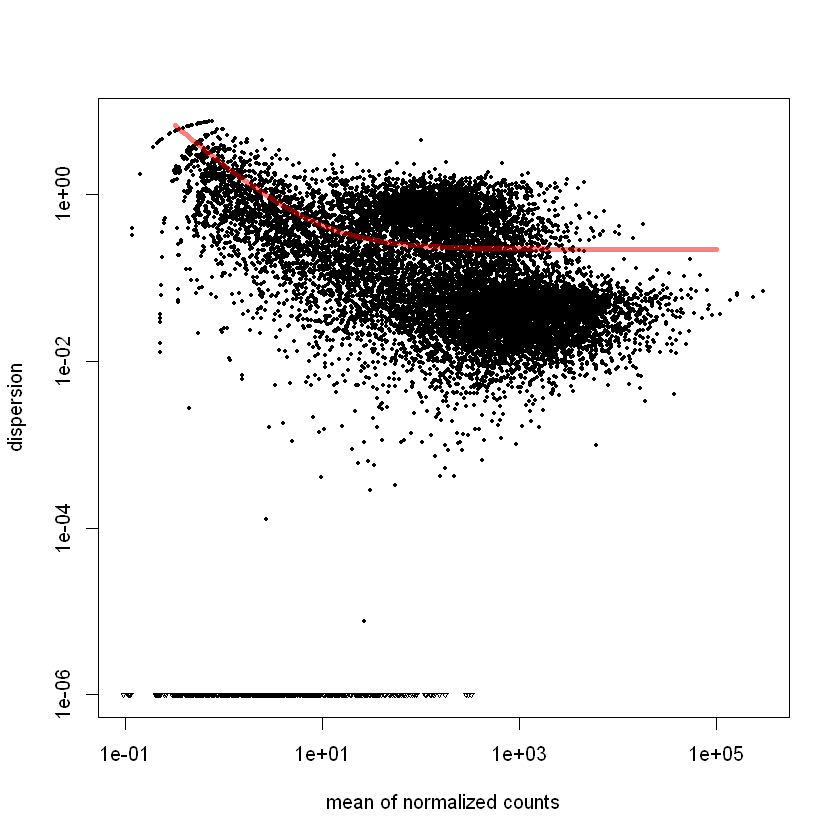

In [45]:
## 1-4. estimate dispersion
# estimateDispersions : estimate dispersion 에 사용
cds = estimateDispersions(cds)
plotDispEsts(cds)

In [50]:
## 1-5. DEG (none vs. oxaliplatin)
# nbionomTest : DEG 계산
# treatment의 none과 oxaliplatin 부분 볼 것 
res_oxa = nbinomTest(cds, "none", "oxaliplatin")
head(res_oxa) # padj은 FDR값

id,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj
A1BG,0.1630108,0.00000,0.3260216,Inf,Inf,0.9897348,1.0000000
A2M,8.6246102,10.05862,7.1905978,0.7148690,-0.4842492,0.5673162,0.9746172
A3GALT2,0.1633249,0.00000,0.3266498,Inf,Inf,0.9948780,1.0000000
A4GALT,1822.6794976,1428.64706,2216.7119351,1.5516162,0.6337718,0.2453570,0.8163825
AAAS,1524.1272614,1634.43975,1413.8147693,0.8650149,-0.2092031,0.7505064,1.0000000
AACS,1671.1642394,1386.63719,1955.6912889,1.4103843,0.4960883,0.3599146,0.8695973


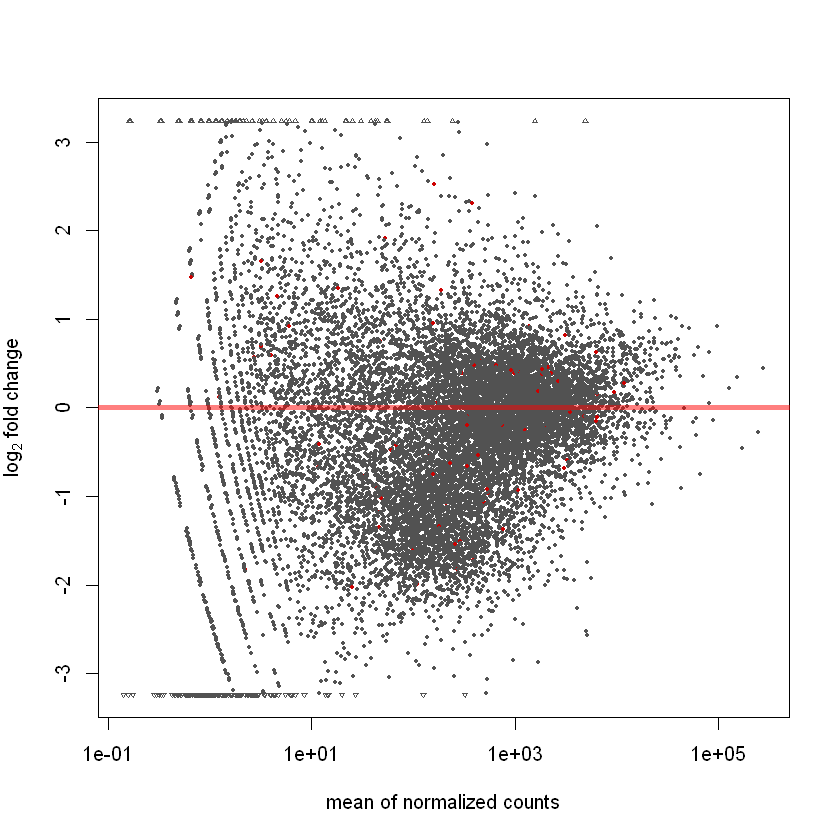

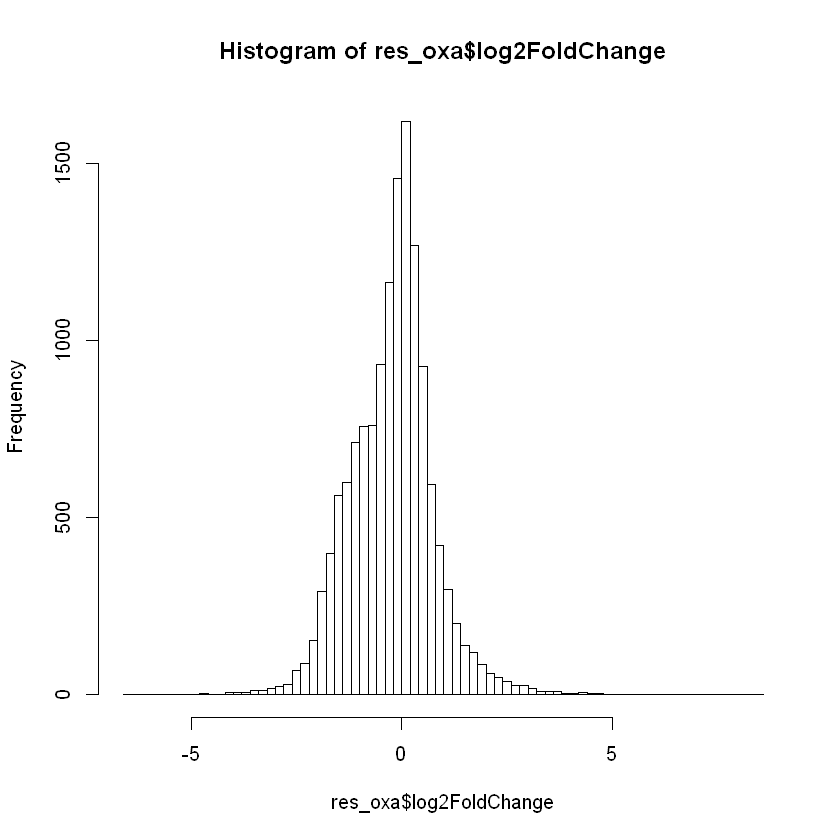

In [48]:
# 시각화 시켜 알아보기
plotMA(res_oxa) # 빨갛게 보여지게 되는 것은 FDR 값이 0.1이하인 굉장히 유의한 수준에 있는 값들 나타냄
hist(res_oxa$log2FoldChange, breaks = 100) # 실제적으로 FoldChange의 분포가 어찌되어있는지

In [54]:
## filtering
# abs : 절대값 씌워준 것
fil.res_oxa = res_oxa[which(abs(res_oxa$log2FoldChange) > 1 & res_oxa$pval < 0.005), ]
dim(fil.res_oxa) # 위의 기준에 만족하는 것들만 나올 것
head(fil.res_oxa) # log2FoldChange, pval가 위의 기준에 만족한 것들만 나온 것을 볼 수 있음 

[1] 204   8

,id,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj
56,ABCG1,243.26597,20.55619,465.975761,22.6683937,4.502610,2.487432e-11,1.255075e-07
167,ACTC1,76.29512,119.66314,32.927096,0.2751649,-1.861632,4.600288e-03,3.516897e-01
169,ACTG2,34.87395,61.51969,8.228209,0.1337492,-2.902398,4.889297e-04,8.132889e-02
262,ADGRG3,100.11572,19.40321,180.828240,9.3195033,3.220253,1.412589e-06,1.045246e-03
282,ADM2,138.00102,53.94030,222.061747,4.1168060,2.041525,8.338211e-04,1.179584e-01
287,ADORA1,268.48095,129.46650,407.495392,3.1474968,1.654205,3.954319e-03,3.235488e-01


In [65]:
## significant genes
# 위의 조건보다 더 구체적으로 filtering 하기
sig.oxa_df = res_oxa[which(abs(res_oxa$log2FoldChange) > 1 & res_oxa$pval < 0.05 & res_oxa$padj < 0.1), ]
dim(sig.oxa_df)
head(sig.oxa_df)

# 위의 조건에 해당하는 id만 가져오고 싶을떄
sig.oxa = res_oxa$id[which(abs(res_oxa$log2FoldChange) > 1 & res_oxa$pval < 0.05 & res_oxa$padj < 0.1)]
length(sig.oxa)
head(sig.oxa)

[1] 100   8

,id,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj
56,ABCG1,243.26597,20.55619,465.975761,22.66839369,4.502610,2.487432e-11,1.255075e-07
169,ACTG2,34.87395,61.51969,8.228209,0.13374921,-2.902398,4.889297e-04,8.132889e-02
262,ADGRG3,100.11572,19.40321,180.828240,9.31950334,3.220253,1.412589e-06,1.045246e-03
368,AHRR,347.71545,576.40622,119.024685,0.20649445,-2.275825,1.949343e-04,4.539569e-02
413,AKR1B10,23.11726,40.31204,5.922472,0.14691568,-2.766940,5.211577e-04,8.392303e-02
487,ALPP,322.59312,617.25440,27.931842,0.04525175,-4.465883,1.038113e-07,1.571392e-04


[1] 100

[1] "ABCG1"   "ACTG2"   "ADGRG3"  "AHRR"    "AKR1B10" "ALPP"

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0.00000,0.000000,0.0000,0.0000000,0.9780649,0.000000,3.151802,1.256601,0.00000
A2M,14.62833,3.177437,12.3701,15.6791893,4.8903247,1.002279,21.012010,33.928220,22.45074
A3GALT2,0.00000,0.000000,0.0000,0.9799493,0.0000000,0.000000,1.050601,0.000000,0.00000
A4GALT,937.93404,1699.928988,1648.0782,2241.1441269,2228.0319454,2180.959733,1495.004526,2085.957235,1404.63518
AAAS,974.93510,1961.537998,1966.8462,1387.6082570,1362.4444688,1491.391582,1992.989168,2565.978720,1497.36648
AACS,996.44735,1672.391198,1491.0730,1916.7808974,1930.7002020,2019.592767,1783.919666,2111.089250,1863.41109


[1]      0.0 470145.9

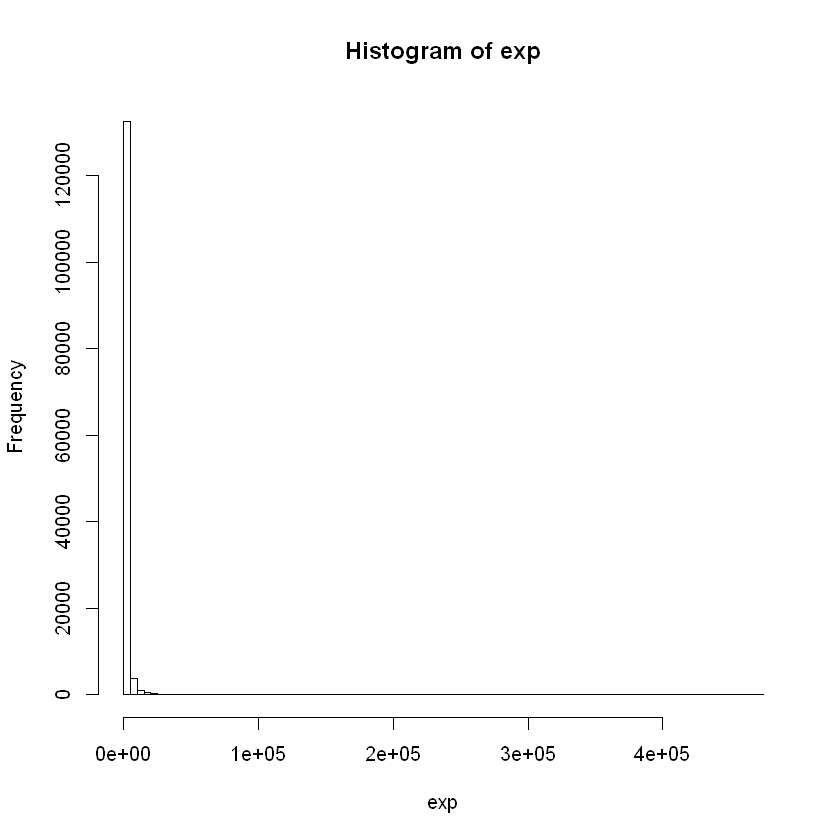

In [66]:
## HEATMAP
# 위 100개의 유전자가 정말 유의한지 heatmap을 통해서 알아보기
# normalized data가져오기

exp = counts(cds, normalized=TRUE)
head(exp)
range(exp) # 범위가 0 - 470145까지 너무 넓음
hist(exp, breaks = 100) # hist를 봐도 0에 모여있음 -> log2로 변환시켜줘야함

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
A1BG,0.000000,0.000000,0.000000,0.0000000,0.9840898,0.000000,2.053737,1.174151,0.000000
A2M,3.966092,2.062618,3.740939,4.0599773,2.5583472,1.001643,4.460219,5.126321,4.551561
A3GALT2,0.000000,0.000000,0.000000,0.9854635,0.0000000,0.000000,1.036046,0.000000,0.000000
A4GALT,9.874880,10.732107,10.687444,11.1306633,11.1222016,11.091409,10.546899,11.027185,10.457006
AAAS,9.930641,10.938505,10.942402,10.4394239,10.4130402,10.543410,10.961442,11.325856,10.549175
AACS,9.962097,10.708559,10.543102,10.9052222,10.9156555,10.980563,10.801643,11.044455,10.864504


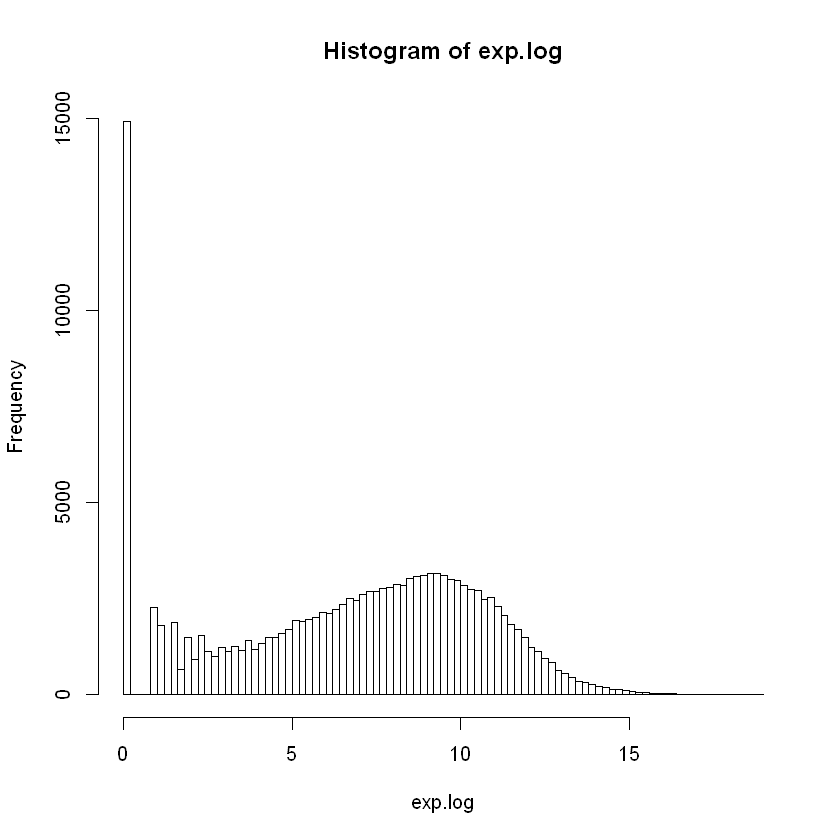

In [67]:
# data값을 log2로 변환시키기
exp.log = log2(exp+1) # 0값이 들어가있으므로 +1 시켜주기 
head(exp.log) # log값으로 변환되어 scale값이 줄어듦
hist(exp.log, breaks=100) # 0값이 많긴하지만, 정규분포의 형태를 띄는 것을 볼 수 있음

In [74]:
## filtering
# 목적 : 100개의 유전자 이용해서 heatmap으로 보이고 싶어하는 것 
colnames(exp.log) # 총 9개의 data, but 내가 분석한 데이터100개는 control과 oxaliplatin만 가져온 data
sig.exp.oxa = exp.log[sig.oxa, ] 
dim(sig.exp.oxa)
range(sig.exp.oxa) # 0부터 13까지 분포가 되어있음

[1] "Sample_97L_1"       "Sample_97L_2"       "Sample_97L_3"      
[4] "Sample_97L_P_AC_1"  "Sample_97L_P_AC_2"  "Sample_97L_P_AC_3" 
[7] "Sample_97L_P_SRC_1" "Sample_97L_P_SRC_2" "Sample_97L_P_SRC_3"

[1] 100   9

[1]  0.00000 13.81797

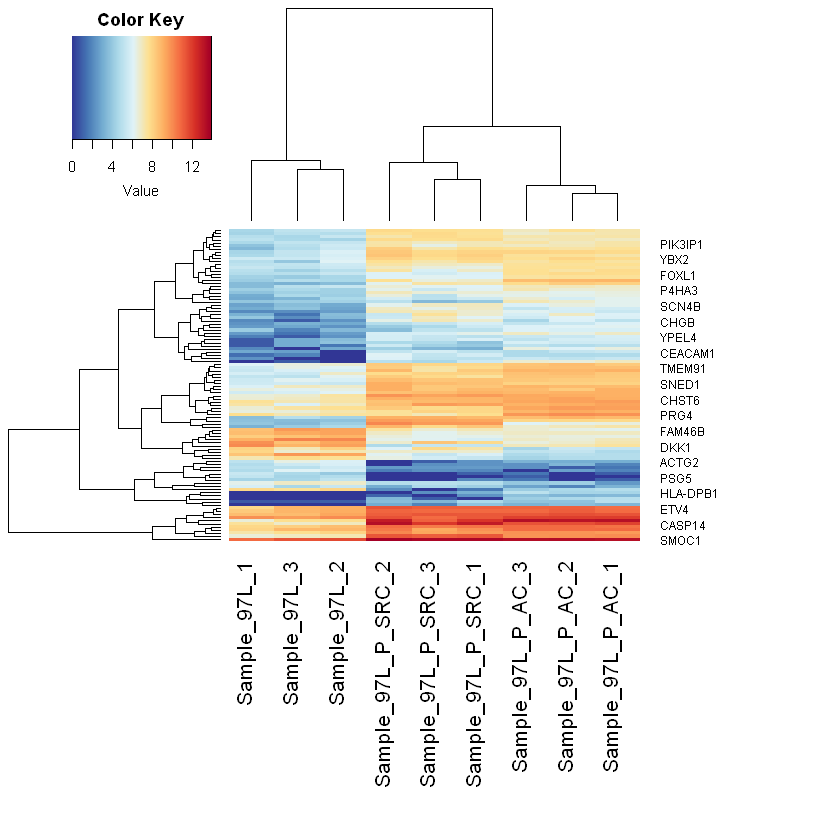

In [75]:
# heatmap.2 : heatmap 그리는 함수, matrix파일 들어감
# col : 색 지정
# margin : 그래프 영역지정
col = colorRampPalette(brewer.pal(10, "RdYlBu"))(256)
heatmap.2(sig.exp.oxa, scale = "none", col = rev(col), margins=c(15, 10), trace = "none", density.info = "none")

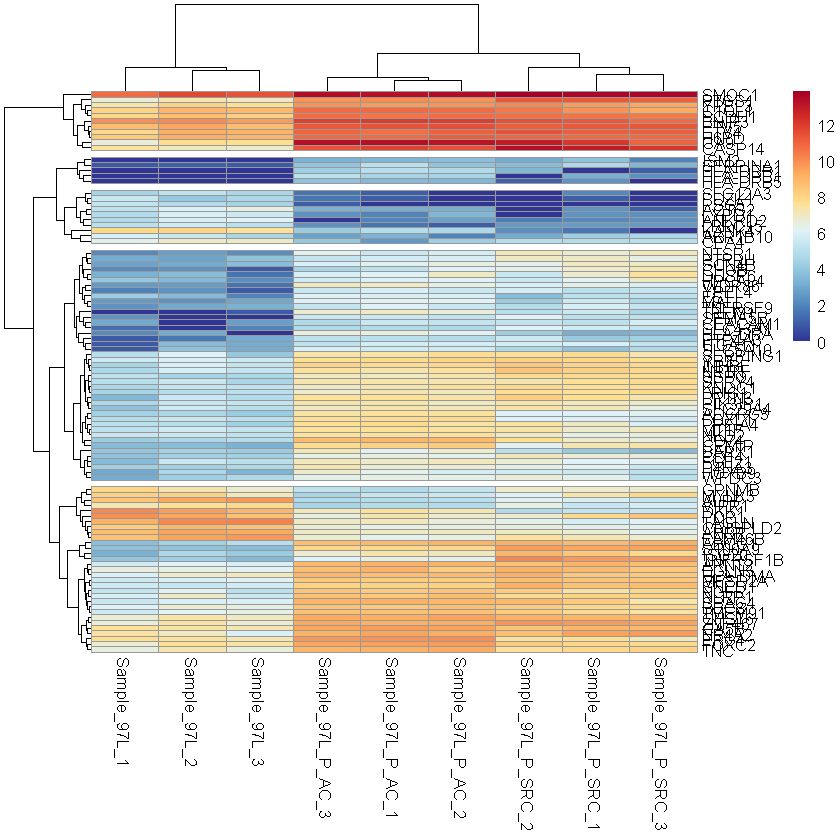

In [77]:
## cutree
# row cut하고 싶을 때 
# row 5개로 cut
pheatmap(sig.exp.oxa, cutree_rows = 5, col = rev(col), margins = c(15, 10), trace = "none", density.info = "none")

id,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj
A1BG,0.7347337,0.00000,1.4694674,Inf,Inf,0.4111136,0.7974627
A2M,17.9278057,10.05862,25.7969888,2.564664,1.3587699,0.1206198,0.5905541
A3GALT2,0.1751001,0.00000,0.3502002,Inf,Inf,0.9742308,1.0000000
A4GALT,1545.2563532,1428.64706,1661.8656463,1.163244,0.2181542,0.7055905,0.9593684
AAAS,1826.6089377,1634.43975,2018.7781219,1.235150,0.3046862,0.5989222,0.9096807
AACS,1653.0552622,1386.63719,1919.4733344,1.384265,0.4691202,0.3970164,0.7855691


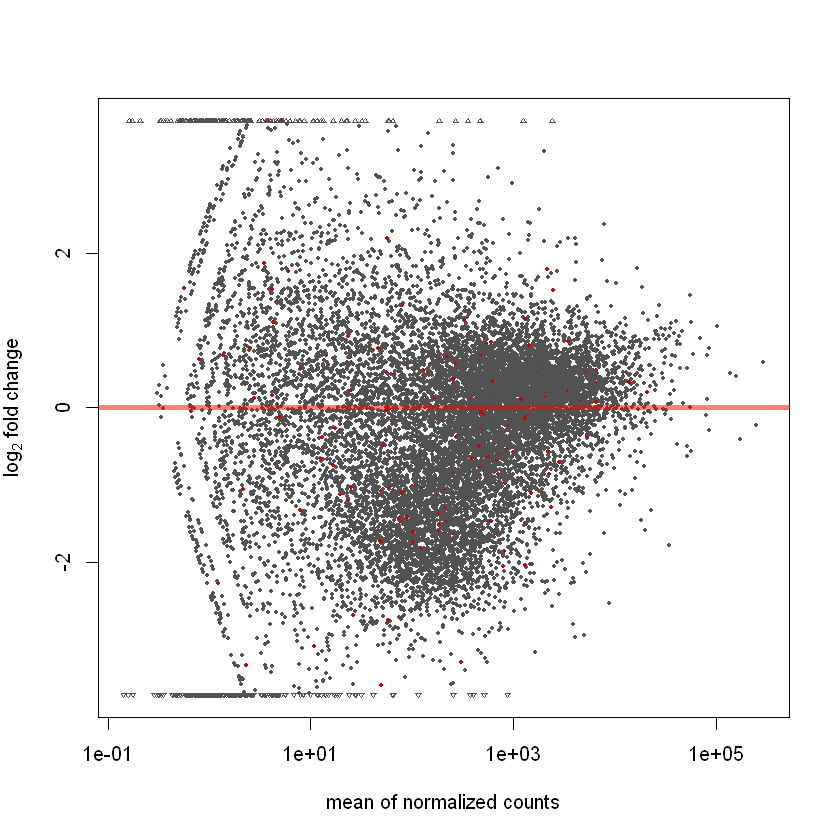

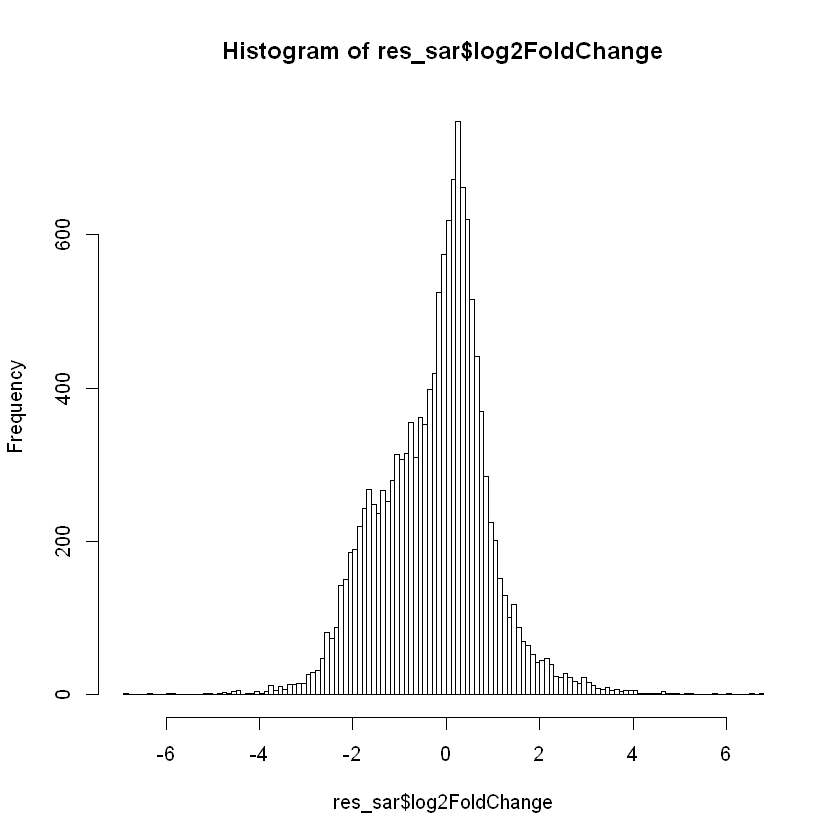

In [79]:
## 1-5. DEG (none vs. saracatinib)
res_sar = nbinomTest(cds, "none", "saracatinib")
head(res_sar)

plotMA(res_sar)
hist(res_sar$log2FoldChange, breaks = 100) # 분포결과 보기

In [84]:
## filterting
fil.res_sar = res_sar[which(abs(res_sar$log2FoldChange) > 1 &res_sar$pval < 0.005), ]
dim(fil.res_sar)

## significant genes
sig.sar=res_sar[which(abs(res_sar$log2FoldChange) > 1 & res_sar$pval < 0.05 & res_sar$padj < 0.1), ]
dim(sig.sar)
head(sig.sar)

# id만 출력
sig.sar=res_sar$id[which(abs(res_sar$log2FoldChange) > 1 & res_sar$pval < 0.05 & res_sar$padj < 0.1)]
length(sig.sar)

[1] 363   8

[1] 236   8

,id,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj
16,AARD,385.71048,612.84974,158.571221,0.25874405,-1.950402,1.210858e-03,8.424352e-02
56,ABCG1,268.81914,20.55619,517.082098,25.15457144,4.652749,7.967908e-12,1.726418e-08
167,ACTC1,64.33478,119.66314,9.006412,0.07526471,-3.731883,3.570040e-07,2.005437e-04
169,ACTG2,31.62293,61.51969,1.726174,0.02805888,-5.155399,3.174382e-07,1.851764e-04
260,ADGRG1,1166.93156,1845.29865,488.564479,0.26476174,-1.917233,1.252151e-03,8.474131e-02
287,ADORA1,365.97867,129.46650,602.490837,4.65364277,2.218360,1.971355e-04,2.285761e-02


[1] 236

[1] 236   6

[1]  0.00000 14.16451

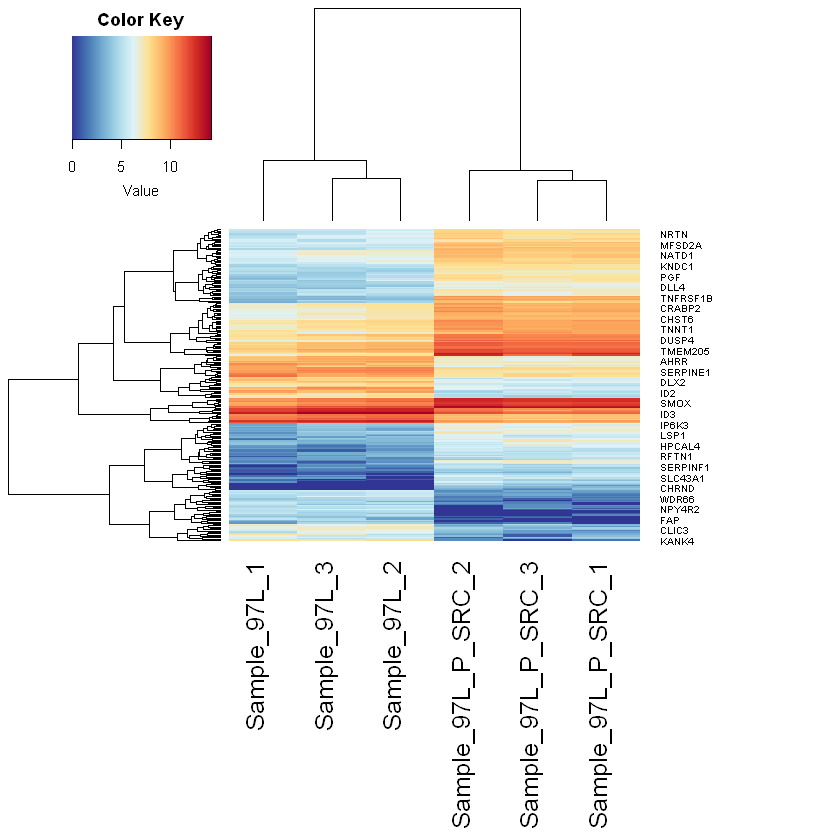

In [83]:
# heatmap 그리기
sig.exp.sar=exp.log[sig.sar, c(1:3, 7:9)] # log로 값 변환 # 1:3은 none, 7:9는 sar
dim(sig.exp.sar)
range(sig.exp.sar)
heatmap.2(sig.exp.sar, scale = "none", col=rev(col), margins=c(15,10), trace = "none", density.info = "none") 

[1] 69

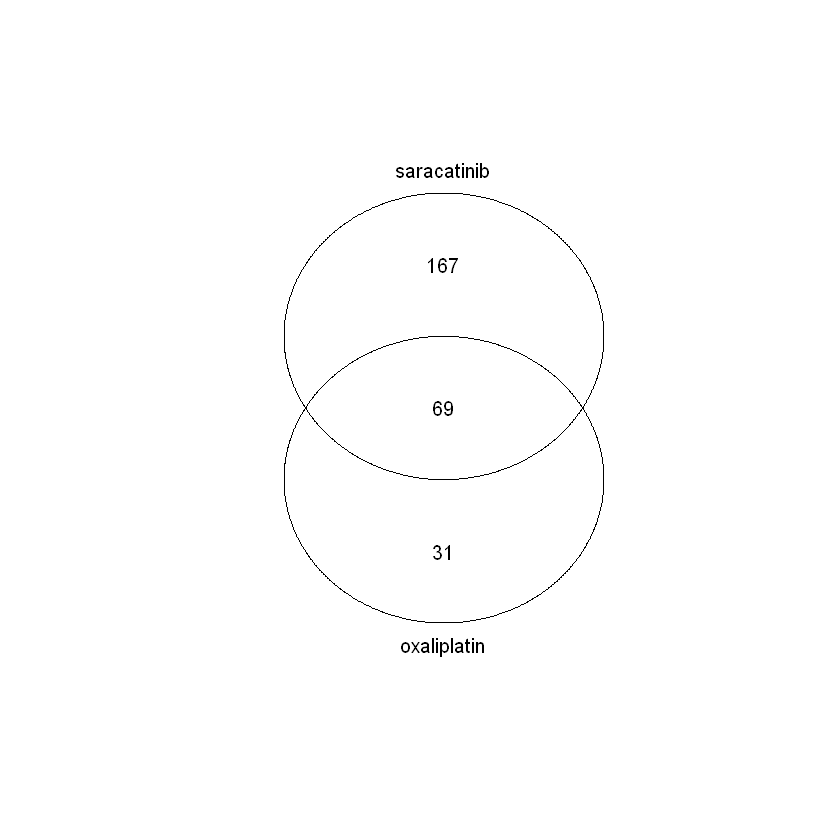

In [90]:
## 1-6. DEG (common genes with alteration by treating drugs)
# control에 비해서 두개의 약물(oxa 100개, sar 236개)에 다 반응하고 있는 gene을 보고싶을 때
# intersect : 두 그룹의 공통된 부분 묶어주기
com.id = intersect(sig.oxa, sig.sar)
length(com.id) # 69개의 gene이 oxa와 sar 두 약물에 반응함

# 벤다이어그램으로 나타내주기
venn(list(oxaliplatin = sig.oxa, saracatinib = sig.sar), small = 1)

[1] 69  9

,Sample_97L_1,Sample_97L_2,Sample_97L_3,Sample_97L_P_AC_1,Sample_97L_P_AC_2,Sample_97L_P_AC_3,Sample_97L_P_SRC_1,Sample_97L_P_SRC_2,Sample_97L_P_SRC_3
ABCG1,3.705631,4.400795,4.930640,8.810047,9.050211,8.720953,8.802370,9.083732,9.1426094
ACTG2,5.146476,6.012317,6.452706,3.143980,3.141518,3.324885,2.379178,0.000000,0.9826698
AHRR,8.723286,9.422627,9.283809,6.913534,6.945539,6.861237,6.655453,6.896278,6.3054146
ALPP,8.484232,9.354234,9.717962,4.878653,4.969013,4.703598,5.952679,6.255426,5.3582864
ANKRD2,4.790521,5.836296,6.177240,1.978140,2.779972,0.000000,2.053737,1.812786,2.2940990
ARNT2,5.669832,6.169179,5.836460,9.074121,9.039525,8.855027,9.025270,8.632375,8.7628697


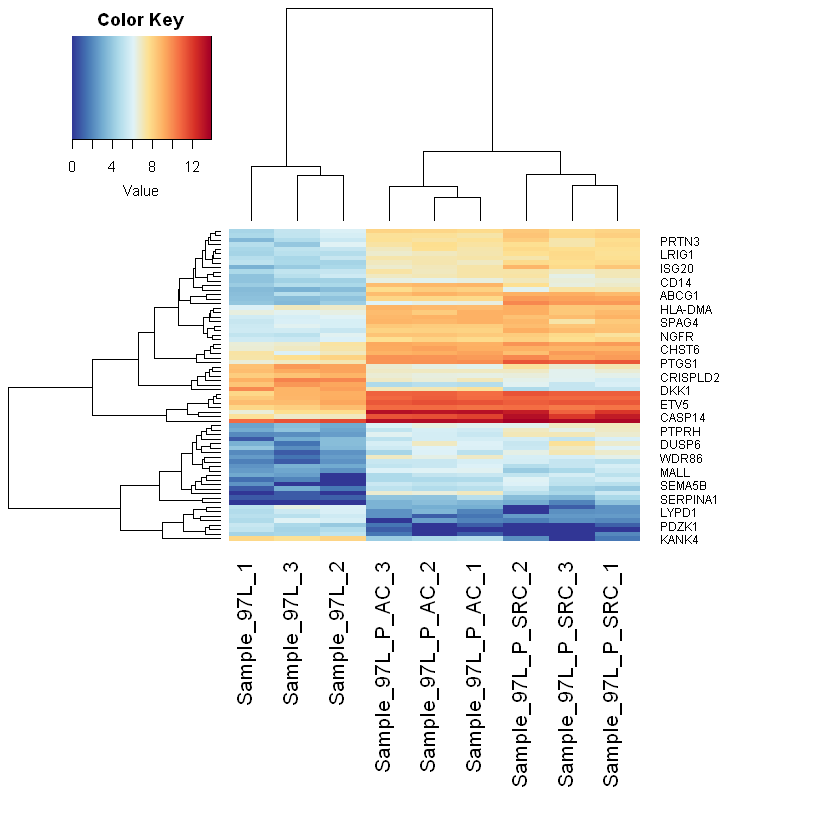

In [91]:
# 69개의 유전자를 가지고 heatmap으로 결과 보기
com.exp = exp.log[com.id,]
dim(com.exp)
head(com.exp)
heatmap.2(com.exp, scale = "none", col = rev(col), margins = c(15, 10), trace = "none", density.info = "none")

    두가지 약물(oxa, sar)에 의해
    sample_97L_P_AC1, sample_97L_P_AC2, sample_97L_P_AC3, 
    sample_97L_P_SRC1, sample_97L_P_SRC2, sample_97L_P_SRC3은 올라가져있다.(윗부분이 red)
    
    sample_97L_1, sample_97L_2, sample_97L_3은 떨어져 있다.(윗부분 blue)
    
    색 농도의 진함 정도를 통해 진하면 유전자가 더 많이 발현됨을 알 수 있다. 
    
    약물에 대한 expression한 변화가 있음을 보여줌
   ----------------------------------------------------------------------------------------
    * DESeq 최종 정리 
    
    count data → metatdata(basic data of sample) → normalization(값 보정) → dispersion(값 보정)
    이러한 과정을 거쳐 data correction 시켜줌
    
    nbinomeTest를 통해 pval, padj로 data filtering 유용하게 해줄 수 있음
    
    Heatmap tool을 사용해서 data에 대한 정보를 가시적으로 확인 할 수 있음